# Pathway Diagram Building Helper

This can help building a flux diagram of pathway more efficiently with the aid of Chemkin data. It could be seen as a complementary code for the mechanism analyzer, offering the result:

- The flux to important products from certain species

- The ratio of the flux between the reactant flux and a certain flux

In [1]:
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.rmg.pdep import PDepReaction
from rmgpy.chemkin import loadChemkinFile
from rmgpy.tools.extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV, getFluxGraphEdgesDict
from rmgpy.chemkin import getSpeciesIdentifier
from rmgpy.species import Species
from IPython.display import display, Image
import os
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import networkx as nx
import re
import pydot
%matplotlib inline

### INPUT

please save 

- annotated chemkin files (mechanism and species dictionary) and 

- chemkin simulation ckcsv file 

under ./data/pathway_analysis/`mech` and input `mech` variable in the next cell.

In [2]:
mech = 'CPO_8.1'

In [3]:
mechPath = os.path.join('./', 'data', 'pathway_analysis', mech)
chemkinPath= os.path.join(mechPath, 'chem_annotated.inp')
dictionaryPath = os.path.join(mechPath, 'species_dictionary.txt')
ckcsvPath= mechPath + '/CKSoln.ckcsv'

# extract the data to a RMG model
model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath, dictionaryPath, checkDuplicates=False)

# generate paris for reactions that don't have flux pairs
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

# prepare a dict for graph edges
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)
first_col_dict, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

graph_edges_dict = getFluxGraphEdgesDict(spc_rop_dict, model.core.reactions)

graph_edges_dict_simple = {}
for pair in graph_edges_dict:
    node1 = getSpeciesIdentifier(pair[0])
    node2 = getSpeciesIdentifier(pair[1])
    graph_edges_dict_simple[(node1, node2)] = graph_edges_dict[pair]

### INPUT

- `time_investigated` the time point or time scale (for integrated flux) you want to investigate 

- `reactant_name` the chemkin name of your initial species/reactant

- `T` the reaction temperature in K

- `P` the reaction pressure in Pa if the mechanism includes pressure-dependent reactions

- `showIntegratedFlux` True if users want to use time-integrated fluxes (integrated up to the investigated time point) in mole for analysis. False if users want to use instantaneous fluxes in mole/cm3/s at the investigated time point for analysis

In [7]:
time_investigated = 0.004 # unit: second
reactant_name = 'CPO(1)'
T = 1173 # unit: K
P = 8.97*101325 # unit: Pa
showIntegratedFlux = True

In [8]:
timepoint_index = (np.abs(firstColDict['Time_(sec)']-time_investigated)).argmin()
timeList = firstColDict['Time_(sec)']
Plist = firstColDict['Pressure_(atm)']
Tlist = firstColDict['Temperature_(k)']
Vlist = firstColDict['Volume_(cm3)']

print "Investigated time point is {0} secs".format(timeList[timepoint_index])
print "At this moment, the reactant's mole fraction is {}.".format(spc_mf_dict[reactant_name][timepoint_index])

# Create species_identifier_dict for the core species    
species_identifier_dict = {}
for i, s in enumerate(model.core.species):
    species_identifier_dict.update({getSpeciesIdentifier(model.core.species[i]): s})
    
# Create reaction_identifier_dict
rxn_identifier_dict = {}
for i, s in enumerate(model.core.reactions):
    rxn_identifier_dict.update({s.index:i})
    
# Create network
G = nx.DiGraph()

species_total_produce_flux_dict = {}
species_total_consume_flux_dict = {}

for species_symbol, species in species_identifier_dict.iteritems():
    species_total_produce_flux_dict.update({species_symbol: 0})
    species_total_consume_flux_dict.update({species_symbol: 0})
    
    if species_symbol in ['He', 'Ne', 'Ar']:
        continue
    
    for rxn_rop in spc_rop_dict[species_symbol]:
        
        a = re.search('#[0-9]+_',rxn_rop[0])
        rxn_index = int(a.group()[1:-1])
        
        reaction = model.core.reactions[rxn_identifier_dict[rxn_index]]
        if showIntegratedFlux:
            flux = simps(rxn_rop[1][:timepoint_index+1],timeList[:timepoint_index+1],)
        else:
            flux = rxn_rop[1][timepoint_index]
            
        if flux >= 0:
            species_total_produce_flux_dict[species_symbol] += flux
        else:
            species_total_consume_flux_dict[species_symbol] += -flux
            
            if species in reaction.reactants:
                for product in reaction.products:
                    node = getSpeciesIdentifier(product)
                    if G.has_edge(species_symbol, node):
                        G[species_symbol][node]['total_flux'] += -flux
                        G[species_symbol][node]['rxn'].append(reaction)
                    else:
                        G.add_edge(species_symbol, node, total_flux = -flux, rxn = [reaction,])
            else:
                for reactant in reaction.reactants:
                    node = getSpeciesIdentifier(reactant)
                    if G.has_edge(species_symbol, node):
                        G[species_symbol][node]['total_flux'] += -flux
                        G[species_symbol][node]['rxn'].append(reaction)
                    else:
                        G.add_edge(species_symbol, node, total_flux = -flux, rxn = [reaction,])
reactantConsumption = species_total_consume_flux_dict[reactant_name]

Investigated time point is 0.00399 secs
At this moment, the reactant's mole fraction is 0.004734242.


TypeError: unsupported operand type(s) for +=: 'int' and 'tuple'

## Generate Flux diagram
### INPUT

- `species` the chemkin name of the species of the inital layer

- `spc_num` the number of species, which have the largest fluxes from/to the species you want to look at

- `pct_coverage` the percentage of the flux be covered from/to the species. 

- `pct_initial` the threshold to determine where the branches end

- `hierarchy` the number of layer to be built

In [6]:
spc_num = 4
pct_coverage = 0.99
pct_initial = 0.01
hierarchy = 5
pngName = 'flux.png'

Display the flux diagram in labels

In [15]:
from_species = True
species = reactant_name

structure = [[species,],]
spc_involved = []
level = 0
DG = nx.DiGraph()

spc_num_default = spc_num
pct_coverage_default = pct_coverage

while level <= hierarchy:
    for current_node in structure[level]:
        
        if current_node in spc_involved:
            continue
        else:
            spc_involved.append(current_node)
            if level == hierarchy:
                continue
            
        if level ==0:
            pct_coverage = 0.99
            spc_num = 8
        else:
            pct_coverage = pct_coverage_default
            spc_num =spc_num_default

        print "Level {0}".format(level + 1)   
        print '************************************************************************'
        
        structure.append([])
        nextNode_flux_list = [(next_node, G[current_node][next_node]['total_flux']) for next_node in G[current_node]]
        sorted_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
        coverage = 0
        
        repeated_flux = 0
        for item in sorted_flux_list:
            repeated_flux += item[1]
            
        if species_total_consume_flux_dict[current_node] == 0:
            print "{0} is the end node with no flux.".format(current_node)
            continue

        for index in range(spc_num):
            structure[level+1].append(sorted_flux_list[index][0])
            step_flux = sorted_flux_list[index][1]
            ratio_initial_species = step_flux / reactantConsumption
            coverage += step_flux / repeated_flux
            
            DG.add_edge(current_node, sorted_flux_list[index][0], flux_pct = ratio_initial_species)
            print "{0} --> {1} \t\t {2:.3f}%".\
            format(current_node, sorted_flux_list[index][0], ratio_initial_species*100)
            
            if index == 0 and ratio_initial_species <= pct_initial:
                print "{0} is the branch end with little flux.".format(current_node)
                break

            if coverage >= pct_coverage:
                break

        print '************************************************************************'
        
    level +=1

Level 1
************************************************************************
CPO(1) --> C5H8O(683) 		 48.338%
CPO(1) --> H2(6) 		 31.053%
CPO(1) --> CPO-2(677) 		 26.388%
CPO(1) --> CPO-3(678) 		 14.362%
CPO(1) --> C2H4(37) 		 6.772%
CPO(1) --> C5H8O(690) 		 4.257%
CPO(1) --> C5H8O(684) 		 3.983%
CPO(1) --> CH4(14) 		 2.346%
************************************************************************
Level 2
************************************************************************
C5H8O(683) --> CO(10) 		 48.308%
C5H8O(683) --> C4H8(706) 		 48.308%
************************************************************************
Level 2
************************************************************************
H2(6) --> H(2) 		 0.003%
H2(6) is the branch end with little flux.
************************************************************************
Level 2
************************************************************************
CPO-2(677) --> CPO-3(678) 		 11.994%
CPO-2(677) --> RO2(680) 		 7.917%


Generate the flux diagram and save it as `flux.png` with pydot

In [16]:
graph = pydot.Dot('flux_diagram', graph_type='digraph', overlap="false")
graph.set_rankdir('LR')
graph.set_fontname('sans')
graph.set_fontsize('10')

speciesRateTolerance = 1e-6  

speciesPath = mechPath +'/Species'
if not os.path.exists(speciesPath):
    os.mkdir(mechPath +'/Species')

# Add a node for each species
for index in spc_involved:
    species = species_identifier_dict[index]
    #imagePath = os.path.join(mechPath, 'Species', '{0}.png'.format(index))
    imagePath = os.path.join(os.path.abspath(mechPath), 'Species', '{0}.png'.format(index))
    with open(imagePath, 'w') as f:
        f.write(species._repr_png_())
    if os.path.exists(imagePath):
        node = pydot.Node(name=index, shape='rectangle', fontcolor='transparent',\
                          image=imagePath)
    else:
        node = pydot.Node(name=index, shape='rectangle')
    graph.add_node(node)
       
# Add an edge for each species-species rate

for reactantIndex, productIndex in DG.edges:
    reactant = species_identifier_dict[reactantIndex]
    product = species_identifier_dict[productIndex]
    edge = pydot.Edge(reactantIndex, productIndex)
    edge_flux = DG[reactantIndex][productIndex]['flux_pct'] * 100
    edge.set_label("{0:.2f}%".format(edge_flux))
    graph.add_edge(edge)

# Generate the coordinates for all of the nodes using the specified program
program = 'dot'     
graph = pydot.graph_from_dot_data(graph.create_dot(prog=program))[0]

graph.write_png(os.path.join(mechPath, pngName))

display the flux diagram
- hint: double click the image to zoom in/out

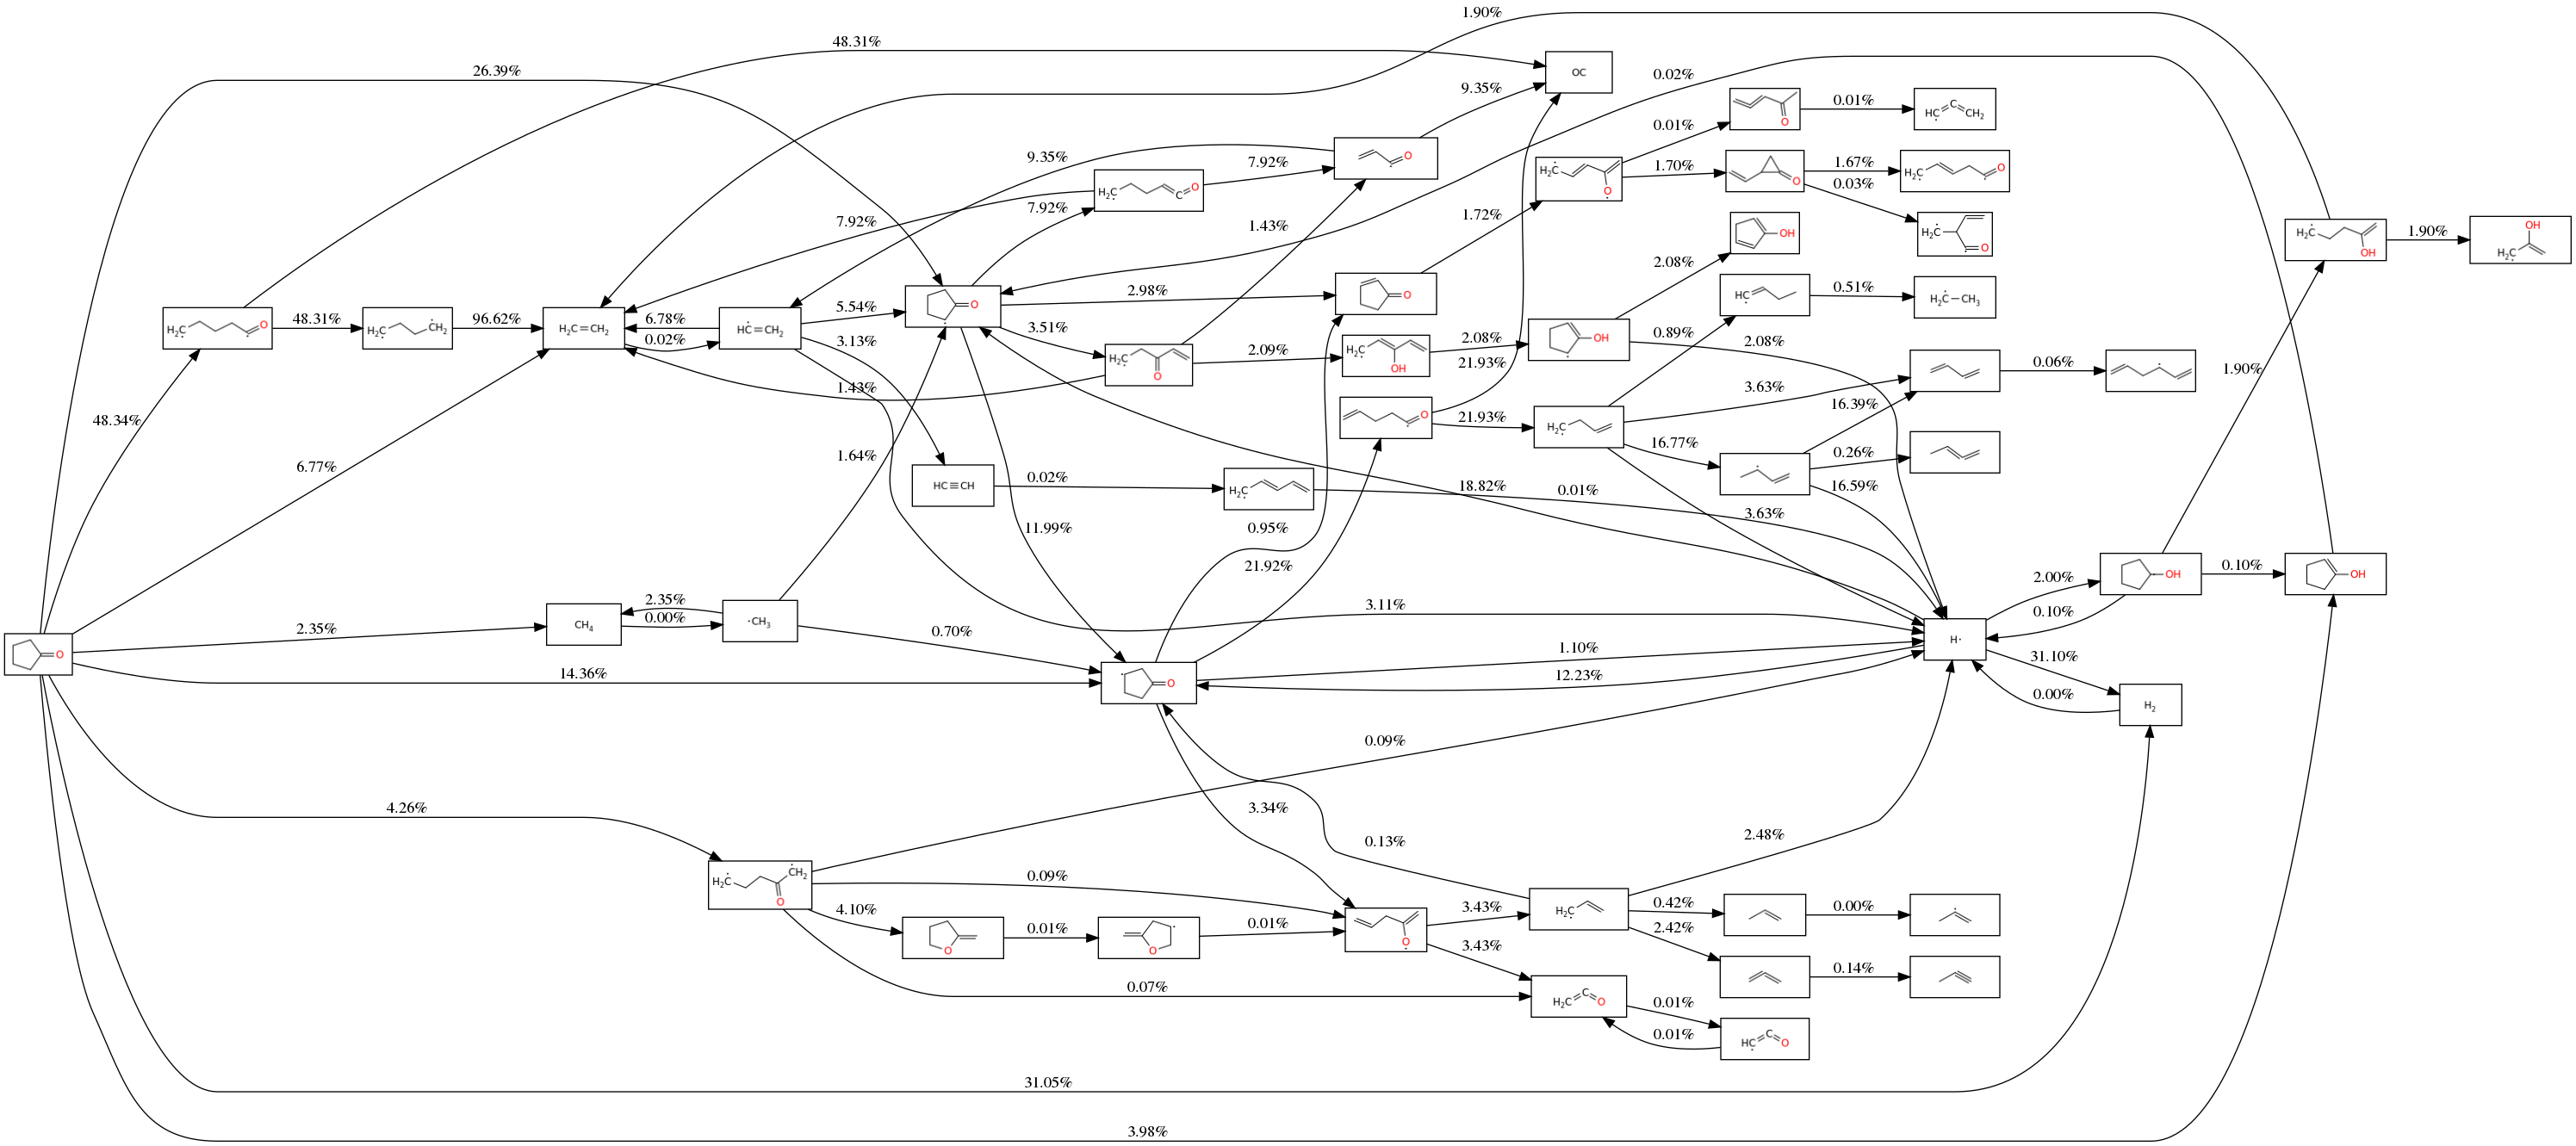

In [17]:
Image(filename=os.path.join(mechPath, 'flux.png'))

## Pathways from/to a species
### Species search

Label CPO(1) represents


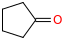

In [34]:
species_label = 'CPO(1)'
if species_label:
    print "Label {0} represents".format(species_label)
    display(species_identifier_dict[species_label])

In [43]:
species_smiles =  "C=CC[CH2]"
if species_smiles:
    search_species = Species().fromSMILES(species_smiles)
    display(search_species)
    for key, key_item in species_identifier_dict.iteritems():
        if key_item.isIsomorphic(search_species):
            print 'has label as {0}'.format(key)
            break

has label as C4H7(192)


### INPUT 

- `from_species` the direction "from a species" (from_species = True) or "to a species" (from_species = False)

- `species` the chemkin name of the species

- `spc_num` the number of species, which have the largest fluxes from/to the species you want to look at

- `pct_coverage` the percentage of the flux be covered from/to the species. 

- `example_rxn_num` the number of example reactions to be shown

The number of output fluxes will be decided on both last criteria and only the smaller one will be reported

In [46]:
from_species = True
species = "C4H7(191)"
spc_num = 6
pct_coverage = 0.99
example_rxn_num = 2

In [47]:
if from_species:
    direction = "From"
    total_species_flux = species_total_consume_flux_dict[species]
else:
    direction = "To"
    total_species_flux = species_total_produce_flux_dict[species]
        
if showIntegratedFlux:
    unit = "mole"   
else:
    unit = "mole/cm3/s"

print "At this moment, the reactant's total molar consumption is {0:.3E} {1}.".\
    format(reactantConsumption, unit)
print ''

if showIntegratedFlux:
    print '{0} {1} given integrated flux'.format(direction, species)
else:
    print '{0} {1} given instantaneous flux'.format(direction , species)
print '======================================'
print 'You are trying to find the top {0} fluxes.'.format(spc_num)
print ''

if from_species:
    nextNode_flux_list = [(next_node, G[species][next_node]['total_flux']) for next_node in G[species]]
    sorted_flux_list = sorted(nextNode_flux_list, key=lambda tup: -tup[1])
else:
    prev_nodes = []
    for node1 in G:
        if species in G[node1]:
            prev_nodes.append(node1)
    prevNode_flux_list = [(prev_node, G[prev_node][species]['total_flux']) for prev_node in prev_nodes]
    sorted_flux_list = sorted(prevNode_flux_list, key=lambda tup: -tup[1])

print "The total flux {0} {1} is {2: .4E} {3}".format(direction, species, total_species_flux, unit)

coverage = 0
repeated_flux = 0
for item in sorted_flux_list:
    repeated_flux += item[1]

for index in range(spc_num):
    step_flux = sorted_flux_list[index][1]
    ratio_initial_species = step_flux / reactantConsumption
    coverage += step_flux / repeated_flux
    
    if from_species:
        species_pair = (species, sorted_flux_list[index][0])
    else:
        species_pair = (sorted_flux_list[index][0], species)
    
    print '************************************************************************'
    print "No.{0}".format(index + 1)
    print "{0} --> {1} \t\t {2:.3E} {3} \t {4:.3f}%".\
    format(species_pair[0], species_pair[1], step_flux, unit, ratio_initial_species*100)
    
    rxn_count = 0
    reaction_list = G[species_pair[0]][species_pair[1]]['rxn']
    for rxn in reaction_list:
        print ''
        print "Example reaction: rxn#{0}".format(rxn.index)
        print rxn
        display(rxn)
        
        if rxn.kinetics.isPressureDependent:
            print 'Forward rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, rxn.getRateCoefficient(T, P))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, reverseRate.getRateCoefficient(T, P))
        else:
            print 'Forward rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, rxn.getRateCoefficient(T))
            reverseRate = rxn.generateReverseRateCoefficient()
            print 'Reverse rate coefficient at {0} K: {1:.2E} mole/cm3/s'.\
            format(T, reverseRate.getRateCoefficient(T))
            
        rxn_count += 1
        if rxn_count >= example_rxn_num:
            break
            
    if coverage >= pct_coverage:
        print ""
        print "{0} major fluxes are found satisfying your coverage.".format(index+1)
        break

At this moment, the reactant's total molar consumption is 2.510E-08 mole.

From C4H7(191) given integrated flux
You are trying to find the top 6 fluxes.

The total flux From C4H7(191) is  4.2019E-09 mole
************************************************************************
No.1
C4H7(191) --> H(2) 		 4.165E-09 mole 	 16.592%

Example reaction: rxn#80
H(2) + C4H6(195) <=> C4H71-3(191)


Forward rate coefficient at 1173 K: 2.29E+07 mole/cm3/s
Reverse rate coefficient at 1173 K: 1.03E+05 mole/cm3/s

Example reaction: rxn#123
[CH2]C=C[CH2](1022) + H(2) <=> C4H71-3(191)


Forward rate coefficient at 1173 K: 3.60E+07 mole/cm3/s
Reverse rate coefficient at 1173 K: 1.52E-02 mole/cm3/s
************************************************************************
No.2
C4H7(191) --> C4H6(195) 		 4.114E-09 mole 	 16.391%

Example reaction: rxn#80
H(2) + C4H6(195) <=> C4H71-3(191)


Forward rate coefficient at 1173 K: 2.29E+07 mole/cm3/s
Reverse rate coefficient at 1173 K: 1.03E+05 mole/cm3/s

Example reaction: rxn#81
H(2) + C4H71-3(191) <=> H2(6) + C4H6(195)


Forward rate coefficient at 1173 K: 3.16E+07 mole/cm3/s
Reverse rate coefficient at 1173 K: 1.00E-03 mole/cm3/s
************************************************************************
No.3
C4H7(191) --> C4H6(208) 		 6.584E-11 mole 	 0.262%

Example reaction: rxn#279
H(2) + C4H612(208) <=> C4H71-3(191)


Forward rate coefficient at 1173 K: 1.17E+07 mole/cm3/s
Reverse rate coefficient at 1173 K: 1.51E+03 mole/cm3/s

Example reaction: rxn#280
H(2) + C4H71-3(191) <=> H2(6) + C4H612(208)


Forward rate coefficient at 1173 K: 2.29E+05 mole/cm3/s
Reverse rate coefficient at 1173 K: 2.51E-04 mole/cm3/s

3 major fluxes are found satisfying your coverage.
